In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error

# Abalone Age Prediction
_CSPB 3022 Data Science Algorithms_

- Author: Sebastian Ojeda
- GitHub: https://github.com/sebsojeda/regression-project

## Topic
**Project Summary:**

The goal of this project is to create a regression model to predict the age of abalone from physical measurements.

**Problem Statement:**

The age of abalone can be determined by counting the number of rings in the shell. However, this can also be predicted using other physical measurements such as the length and diameter.

**Motivation:**

Determining the age of abalone is a boring and time consuming task. A regression model may reduce manual toil by predicting the age given other physical measurements.

## Dataset
**Source:**

The dataset used in this project is provided by the UCI Machine Learning Repository and was donated by S. Waugh, University of Tasmania in 1994. It comes from the study "The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait" by Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and Wes B Ford and can be found at https://archive.ics.uci.edu/ml/datasets/abalone.

**Features:**

The data is summarized by the following:
- 192 KB size
- 4,177 rows
- 9 features

| Name | Data Type | Meas. | Description |
| ---- | --------- | ----- | ----------- |
| Sex  | categorical   | | M, F, and I (infant) |
| Length | continuous | mm | Longest shell measurement |
| Diameter | continuous | mm | Perpendicular to length
| Height | continuous | mm | With meat in shell |
| Whole weight | continuous | grams | Whole abalone |
| Shucked weight | continuous | grams | Weight of meat |
| Viscera weight | continuous | grams | Gut weight (after bleeding) |
| Shell weight | continuous | grams | After being dried |
| Rings | discrete | | +1.5 gives the age in years |

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', 
                 names=['Sex', 'Length', 'Diameter', 'Height','Whole weight',
                        'Shucked weight','Viscera weight', 'Shell weight', 'Rings'])

# draw 5 random samples without replacement
df.sample(n=5, replace=False)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
199,M,0.585,0.460,0.185,0.9220,0.3635,0.2130,0.2850,10
3815,I,0.460,0.340,0.100,0.3860,0.1805,0.0875,0.0965,8
1374,M,0.615,0.480,0.175,1.1180,0.4460,0.3195,0.3000,9
943,I,0.465,0.345,0.110,0.4415,0.1755,0.0905,0.1200,7
1258,I,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,8


## Data Cleaning
**Data Types:**

The data types were correctly set by pandas and do not need to be modified.

In [3]:
df.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object

**NaN Values:**

There are no NaN values in the dataset that need to removed.

In [4]:
# check to see if there are null values in the dataframe
df.isnull().values.any()

False

**Missing Values:**

There are no missing values for the non-numerical feature `Sex`.

In [5]:
# check to see if there are unexpected values in the catergorical feature
df['Sex'].isin(['M', 'F', 'I']).all()

True

**Age:**

The age is given as the number of `Rings` +1.5. Therefore, we will create this column and drop the `Rings` column.

In [6]:
df['Age'] = df['Rings'] + 1.5
df.drop('Rings', axis = 1, inplace = True)

This now leaves us with the following dataset:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Age             4177 non-null   float64
dtypes: float64(8), object(1)
memory usage: 293.8+ KB


## EDA

**EDA Process:**

I will be visualizing a variety of relationships between features and the target class `Age`. This process will include:

1. Using a correlation matrix to idenitfy highly correlated features
2. Plotting a pair plot to examine any relationships
3. Determining outliers with a boxplot
4. Use a violin plot to view the distribution of age by Sex

**Correlation Matrix:**

We now want to quantify the linear relationships we noticed between features in the dataset. Features that have a strong linear correlation may be redundant and do not need to both be included in the regression model.

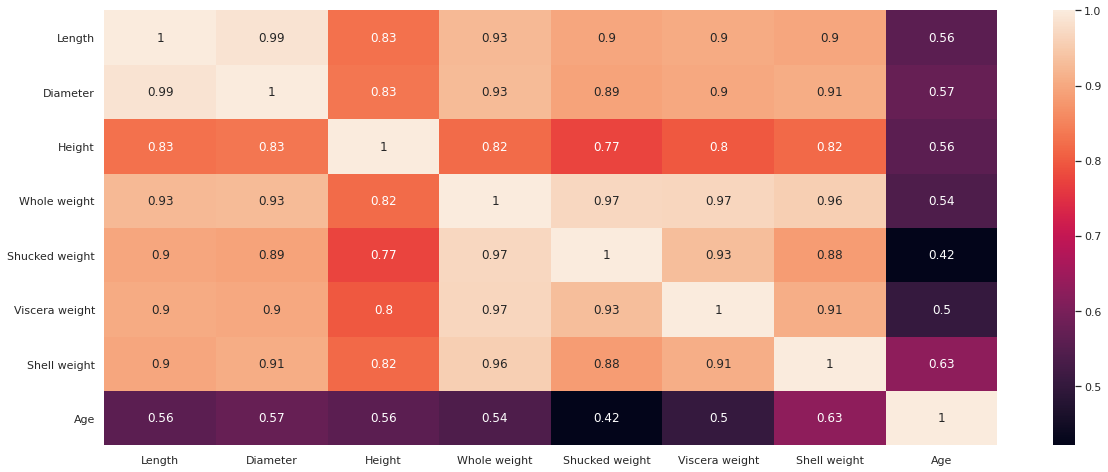

In [8]:
# set a default figure size
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(df.corr(), annot=True)
plt.show()

We can see that some features are highly correlated such as `Whole weight` and `Shucked weight`, `Whole weight` and `Viscera weight`, `Whole weight` and `Shell weight`, and `Length` and `Diameter`. Therefore, we will want to remove some of these redundant features in order to simplify our model. Namely, we may want to drop `Shucked weight`, `Viscera weight`, `Whole weight`, and `Length` in favor of `Shell weight` and `Diameter`.

**Pair Plot:**

We will now plot a pair plot of the quantitative features to examine any correlations between between features in the data.

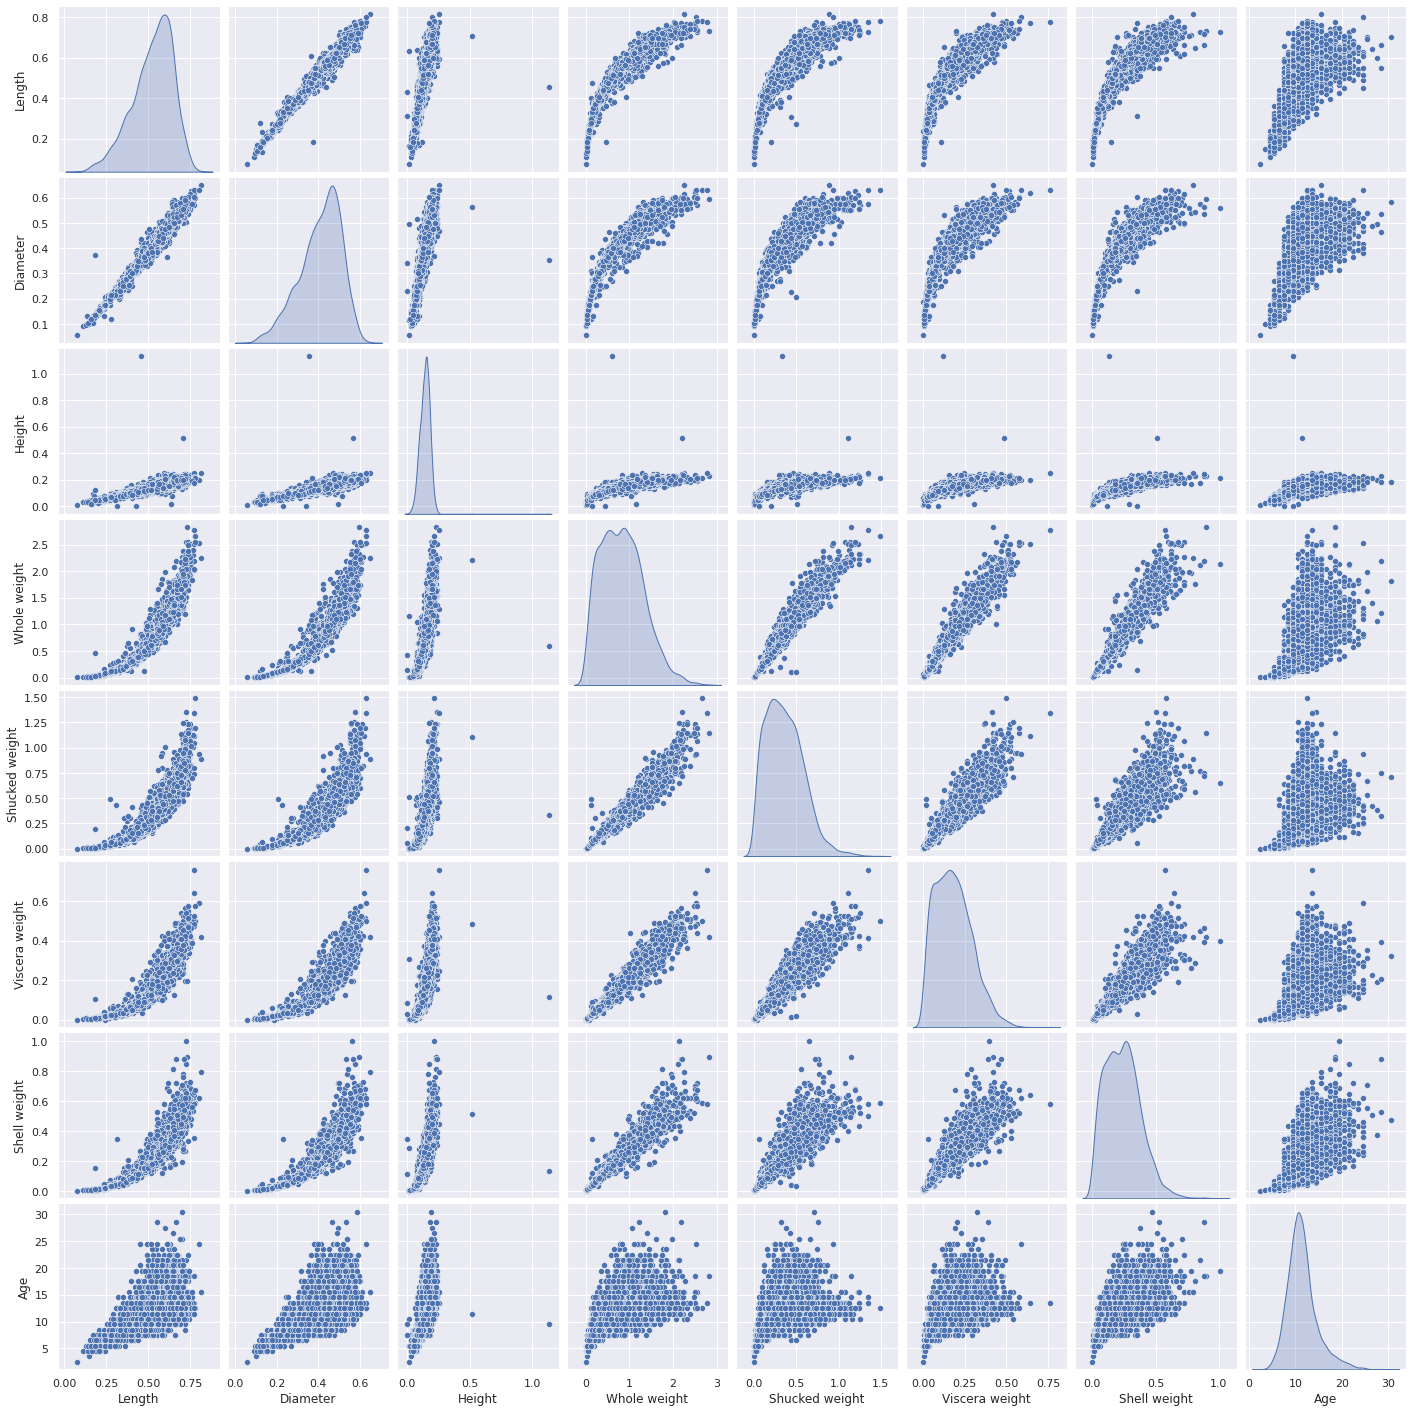

In [9]:
sns.pairplot(df[['Length', 'Diameter', 'Height','Whole weight', 'Shucked weight',
                 'Viscera weight', 'Shell weight', 'Age']], diag_kind='kde')
plt.show()

We can see that there is a (mostly) linear relationship between the target class `Age` and `Whole weight`, `Length`, and `Height`. However, for larger `Age` values, the `Whole weight` and `Length` values are more varied.

**Box Plot:**

A box plot will be used to look for any outliers in the data.

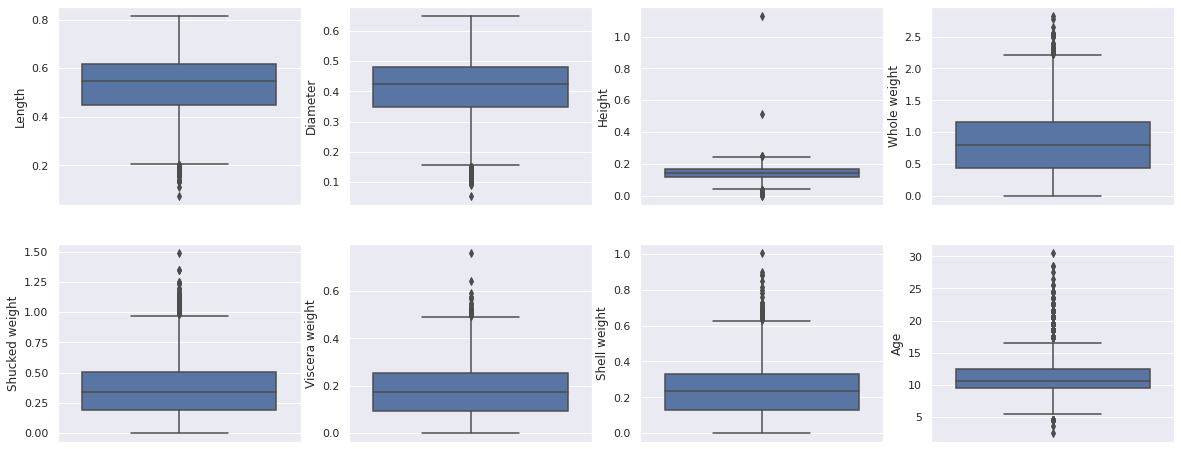

In [10]:
# plot each feature in a separate subplot
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2, ncols=4)
sns.boxplot(ax=ax1, y='Length', data=df)
sns.boxplot(ax=ax2, y='Diameter', data=df)
sns.boxplot(ax=ax3, y='Height', data=df)
sns.boxplot(ax=ax4, y='Whole weight', data=df)
sns.boxplot(ax=ax5, y='Shucked weight', data=df)
sns.boxplot(ax=ax6, y='Viscera weight', data=df)
sns.boxplot(ax=ax7, y='Shell weight', data=df)
sns.boxplot(ax=ax8, y='Age', data=df)
plt.show()

From the boxplots, you can see that there seem to be the most outliers in the higher ranges of the data. We will keep this in mind when evaluating our regression model.

**Violin Plot:**

We now want to examine the distribution of age by sex.

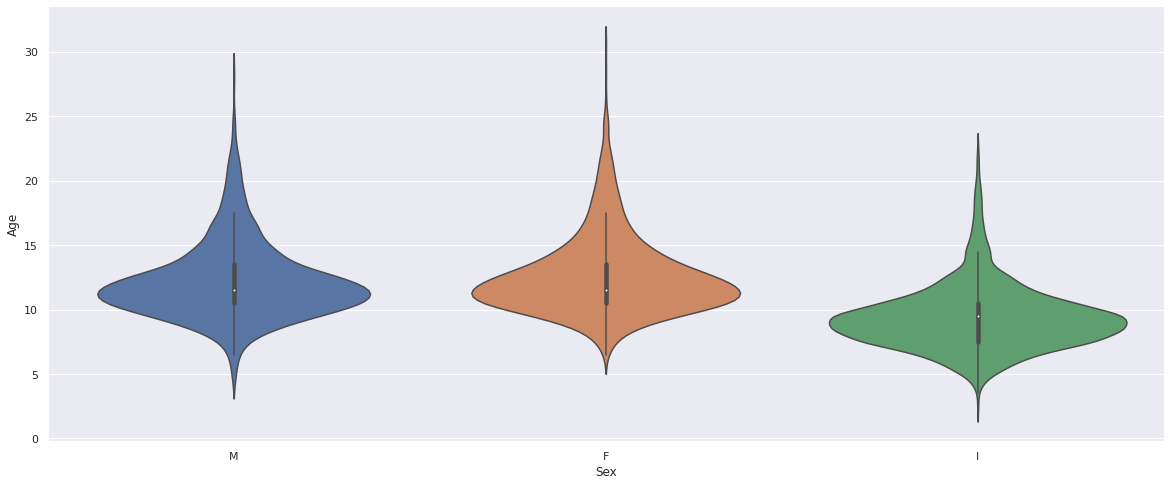

In [11]:
sns.violinplot(x='Sex', y='Age', data=df)
plt.show()

We can see that Male and Female abalones have similar life expectancies so the `Sex` may not have an effect on the prediction. We may choose to exclude this feature from our model. It's also worth noting that the Infant abalones make up most of data points below about 10 years.

**Summary of Findings:**

- There are some highly correlated features in the data
- For all features, the age becomes much more varied as their values increase
- Sex has no noticable effect on the age of abalones
- 3 key features have been identified: `Height`, `Diameter`, and `Shell weight`

**Challenges:**
- The correlations may affect a multi-linear regression model
    - A multi-linear regression model assumes there is no multicollinearity
    - We may address this by using a different approach to our regression model or by dropping the redundant features from the model
- Using our catergorical feature may impact our model
    - We may not want to arbitrarily assign values to these categories as they may skew the results
    - We can avoid this bias by dropping this column

## Model Approach

For this project, I will train two models and then compare their accuracy. One will be a much simpler approach while the other will be an advanced model.

**Model 1: Multi-linear Regression:**

The first model will be a multi-linear regression. This approach was chosen because of its simplicity and ease of interpretation.

We will create models with and without interactions. We we also look at forward stepwise refinement in order to make sure we are choosing the right features in our model.

**Model 2: Random Forest Regressor:**

The more advanced model will be a random forest regressor. This is a machine learning model based on a forest of decision trees. This approach was chosen because its nonlinear nature may give it a leg up over our simpler linear regression approach.

## Multi-linear Regression

**Feature selection using forward stepwise:**

We will use the forward stepwise refinement process to check our intuition that only a handful of features are needed in our model.

In [12]:
# use and equal size test and train dataset
split_size = len(df.index)//2
test = df.loc[np.random.choice(df.index, size=split_size)]
train = df.loc[np.random.choice(df.index, size=split_size)]

Now we will loop through every feature and calculate the $R^2$ value.

In [13]:
def forwardStepwise(formula, features):
    best_feature = None
    best_rsquared = 0
    
    for feature in features:
        model = smf.ols(formula=f'{formula} + {feature}', data=train).fit()
        
        if model.rsquared_adj > best_rsquared:
            best_rsquared = model.rsquared_adj
            best_feature = feature
    
    return (best_feature, best_rsquared)

# features we want to refine
features = ['Length', 'Diameter', 'Height', 'Q("Whole weight")', 
            'Q("Shucked weight")', 'Q("Viscera weight")', 'Q("Shell weight")']

# initial linear regression formula
formula = 'Age~'

# list of rsquared values for test data
rsquared_adj_train = []

# list of rsquared values for training data on each iterative model
rsquared_adj_test = []

iterations = len(features)
for i in range(iterations):
    (best_feature, best_rsquared) = forwardStepwise(formula, features)
    
    formula = f'{formula}+{best_feature}'
    features.remove(best_feature)
    rsquared_adj_train.append(best_rsquared)
    rsquared_adj_test.append(smf.ols(formula=formula, data=test).fit().rsquared_adj)
    print(f"The best feature for iteration {i+1} was {best_feature} with an R-squared of {best_rsquared}")

The best feature for iteration 1 was Q("Shell weight") with an R-squared of 0.3538134944339246
The best feature for iteration 2 was Q("Shucked weight") with an R-squared of 0.4414041311866955
The best feature for iteration 3 was Diameter with an R-squared of 0.46799156786003004
The best feature for iteration 4 was Q("Whole weight") with an R-squared of 0.48186089392315656
The best feature for iteration 5 was Height with an R-squared of 0.48843248249468285
The best feature for iteration 6 was Q("Viscera weight") with an R-squared of 0.4958603737834697
The best feature for iteration 7 was Length with an R-squared of 0.49568228605451226


**R-Squared vs Features**

We will now show the resulting $adjusted R^2$ *vs* number of features for the training data and overlay the results for the test data.

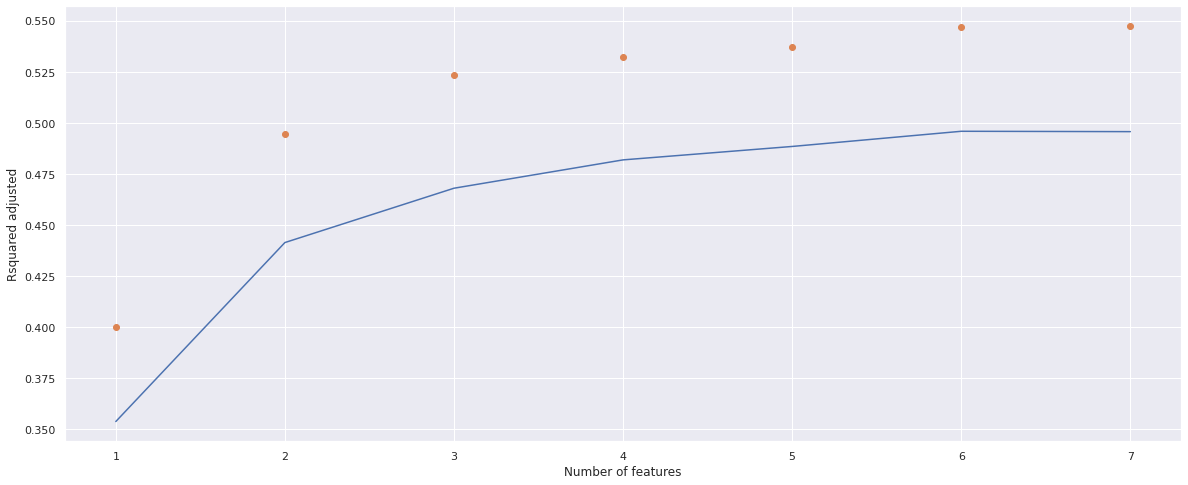

In [14]:
xticks = [i for i in range(1, 8)]

plt.plot(xticks, rsquared_adj_train)
plt.plot(xticks, rsquared_adj_test, 'o')
plt.xticks(xticks)
plt.xlabel('Number of features')
plt.ylabel('Rsquared adjusted')
plt.show()

**Results:**

We can see from our plot that the adjusted $R^2$ value tops out around 3 features. Namely, the `Shell weight`, `Shucked weight`, and `Diameter`. We will use these 3 features in our linear regression model.

**Multi-linear without interactions:**

We will start with a simple linear regression without interactions.

In [15]:
linear_model = smf.ols(formula='Age ~ Q("Shell weight") + Q("Shucked weight") + Diameter', data=df).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     1404.
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        05:16:03   Log-Likelihood:                -9358.9
No. Observations:                4177   AIC:                         1.873e+04
Df Residuals:                    4173   BIC:                         1.875e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.5202      0.246     18.345      0.000       4.037       5.003
Q("Shell weight")      21.3221      0.646     33.005      0.000      20.056      22.589
Q("Shucked weight")   -11.5275      0.383    -30.129      0.000     -12.278     -10.777
Diameter               14.6213      0.947     15.437      0.000      12.764      16.478
==============================================================================
Omnibus:                     1062.927   Durbin-Watson:                   1.345
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3153.860
Skew:                           1.310   Prob(JB):                         0.00
Kurtosis:                       6.355   Cond. No.                         35.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is an _ok_ fit. Our $R^2$ value is $0.502$, but we may be able to do better with interactions.

**Multi-linear with interations:**

In [16]:
linear_model = smf.ols(formula='Age ~ Q("Shell weight") * Q("Shucked weight") * Diameter', data=df).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     666.2
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        05:16:03   Log-Likelihood:                -9248.4
No. Observations:                4177   AIC:                         1.851e+04
Df Residuals:                    4169   BIC:                         1.856e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          4.7630      0.366     13.022      0.000       4.046       5.480
Q("Shell weight")                                 81.4756      4.375     18.624      0.000      72.899      90.052
Q("Shucked weight")                              -19.8524      2.836     -7.000      0.000     -25.413     -14.292
Q("Shell weight"):Q("Shucked weight")            -53.0645     10.205     -5.200      0.000     -73.072     -33.057
Diameter                                           5.7689      1.938      2.977      0.003       1.969       9.569
Q("Shell weight"):Diameter                      -103.9302      7.720    -13.462      0.000    -119.066     -88.794
Q("Shucked weight"):Diameter                      30.3900      5.353      5.677      0.000      19.895      40.885
Q("Shell weight"):Q("Shucked weight"):Diameter    78.6757     14.683      5.358      0.000      49.889     107.463
==============================================================================
Omnibus:                     1040.686   Durbin-Watson:                   1.373
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4237.627
Skew:                           1.171   Prob(JB):                         0.00
Kurtosis:                       7.344   Cond. No.                         636.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here, we can see that the $R^2$ value has improved, but not by much. Our $R^2$ value is now $0.528$. Let's look at our leverage vs residuals to see if we can improve these results.

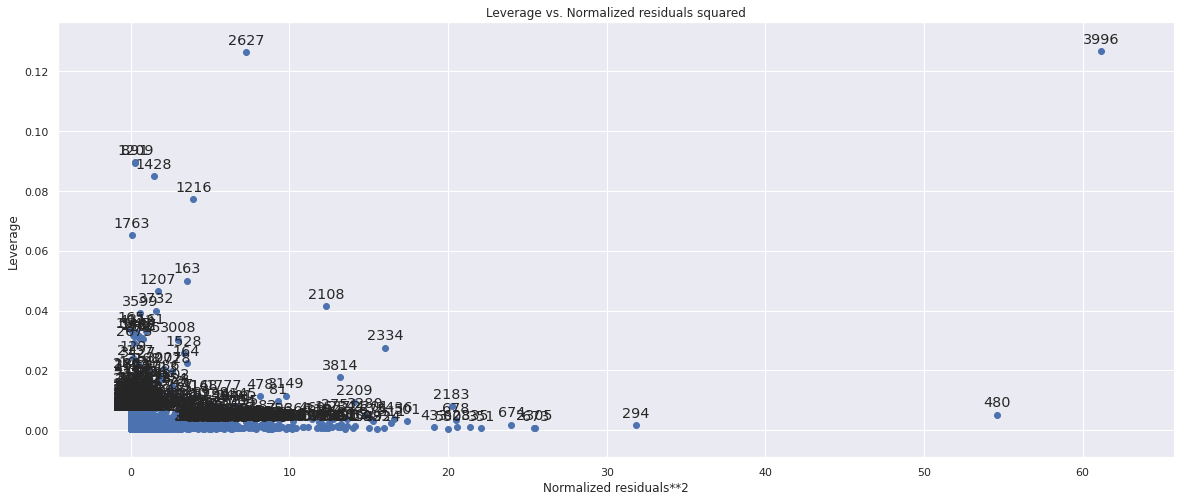

In [17]:
sm.graphics.plot_leverage_resid2(linear_model, alpha=0.05)
plt.show()

We have identified a couple of troublesome points. Let's take a closer look to see what they are.

In [18]:
df.iloc[[2627, 3996, 480]]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
2627,I,0.275,0.205,0.070,0.1055,0.4950,0.0190,0.0315,6.5
3996,I,0.315,0.230,0.000,0.1340,0.0575,0.0285,0.3505,7.5
480,F,0.700,0.585,0.185,1.8075,0.7055,0.3215,0.4750,30.5


Let's drop these outliers to create our final model.

In [19]:
df_linear = df.drop([2627, 3996, 480])
linear_model = smf.ols(formula='Age ~ Q("Shell weight") * Q("Shucked weight") * Diameter', data=df_linear).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     695.5
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        05:16:07   Log-Likelihood:                -9175.1
No. Observations:                4174   AIC:                         1.837e+04
Df Residuals:                    4166   BIC:                         1.842e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          5.0515      0.367     13.762      0.000       4.332       5.771
Q("Shell weight")                                 96.2949      4.606     20.904      0.000      87.264     105.326
Q("Shucked weight")                              -25.2213      2.986     -8.447      0.000     -31.075     -19.367
Q("Shell weight"):Q("Shucked weight")            -62.3637     10.530     -5.922      0.000     -83.009     -41.718
Diameter                                           3.4009      1.989      1.710      0.087      -0.499       7.301
Q("Shell weight"):Diameter                      -129.1127      8.071    -15.998      0.000    -144.936    -113.290
Q("Shucked weight"):Diameter                      43.8362      5.595      7.834      0.000      32.866      54.806
Q("Shell weight"):Q("Shucked weight"):Diameter    90.4050     15.100      5.987      0.000      60.802     120.008
==============================================================================
Omnibus:                      946.136   Durbin-Watson:                   1.389
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2629.000
Skew:                           1.192   Prob(JB):                         0.00
Kurtosis:                       6.072   Cond. No.                         666.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Random Forest Regressor

**Feature Encoding and Test-Train Split:**

We will start by encoding our categorical data and creating our test and training datasets.

In [20]:
# transform categorical data into encoded values
le = LabelEncoder()
df["Sex"] = le.fit_transform(df["Sex"])

# remove dependent variable from X
X = df.drop("Age", axis=1)

y = df["Age"]

# Random state is not so random so that we can have reproducible results for this project
RANDOM_STATE = 11

# 20% of our data will be used as the test set
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=RANDOM_STATE)

rf = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)

**Model Fit and Prediction:**

New we can fit the data and make predictions on our training and test datasets. We will use various metrics including:

- Mean Absolute Error (MAE)
    - Measures the average magnitude of the errors in predictions, without considering their direction. Lower is better.
- Mean Square Error (MSE)
    - Shows how close a regression line is to a set of points. Lower is better.
- Root Mean Square Error (RMSE)
    - RMSE is used to return the MSE error to the original unit by taking the square root of it.
- R-Squared value
    - R-Squared value is the proportion of the variance in the dependent variable that is predicted from the independent variables. Generally, a score higher than 0.7 is considered to have a good level of correlation, 0.5 to 0.7 is a moderate correlation, and a score below 0.4 shows a low level of correlation.

In [21]:
# fit the Random Forest model to the training data
rf_model = rf.fit(X_train, y_train)

# use the model to predict values for the test and training datasets
train = rf_model.predict(X_train)
test = rf_model.predict(X_test)

print(f'Training MAE: {mean_absolute_error(y_train, train)}')
print(f'Test MAE: {mean_absolute_error(y_test, test)}')
print(f'Training MSE: {mean_squared_log_error(y_train, train)}')
print(f'Test MSE: {mean_squared_log_error(y_test, test)}')
print(f'Training RMSE: {np.sqrt(mean_squared_log_error(y_train, train))}')
print(f'Test RMSE: {np.sqrt(mean_squared_log_error(y_test, test))}')
print(f'Training R2: {r2_score(y_train, train)}')
print(f'Test R-Squared: {r2_score(y_test, test)}')

Training MAE: 0.5761807841963484
Test MAE: 1.5182775119617227
Training MSE: 0.0033882795963755025
Test MSE: 0.02422241054764678
Training RMSE: 0.05820893055516054
Test RMSE: 0.15563550542098925
Training R2: 0.9350571051026946
Test R-Squared: 0.556416253594151


We can see that the errors in the test set is higher than in the training set this. We can visualize the prediction vs the actual values.

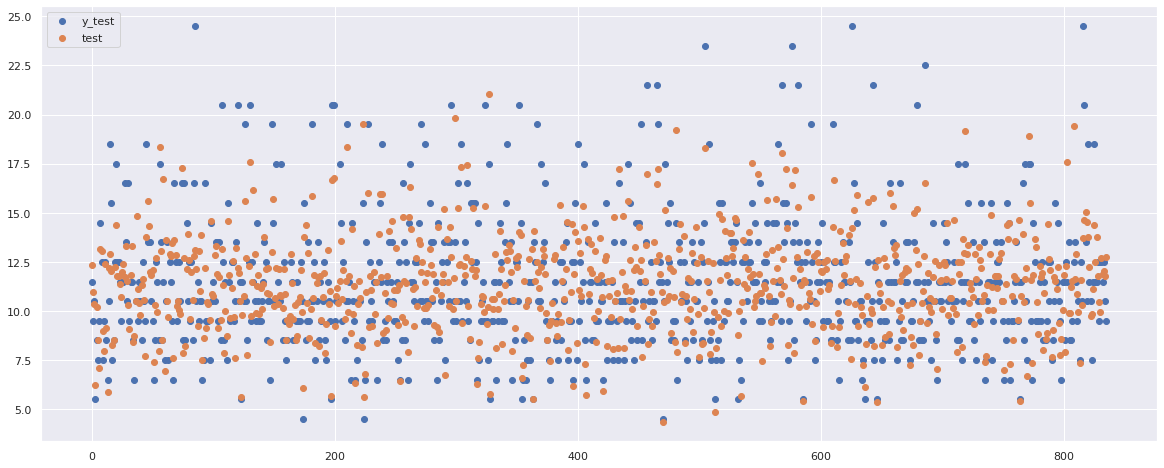

In [22]:
plt.scatter(range(y_test.shape[0]), y_test, label="y_test")
plt.scatter(range(y_test.shape[0]), test, label="test")
plt.legend()
plt.show()

**Results:**

We can see that there is some overlap between our two datasets which indicates that the model does an ok job at predicting values.



## Discussion and Conclusion

**Summary of Results:**

1. The linear model only used 3 parameters to achieve an R-Squared value of $0.54$
2. The random forest achieved an R-Squared value of $0.55$
3. Overall, the Random Forest Regressor had a slightly better R-Squared value than the linear regression.

**Discussion and Improvements:**
Even though the random forest regressor did better than the linear regression model, this improvement was slight. Furthermore, the random forest model is much more complex than the linear regression model. I would probably go with the linear regression model because even though it was not as accurate, it is a much simpler model to digest and understand.

There are some improvements that can be made. Mainly, I could have spent time tuning the parameters of the random forest regressor. This could have improved the error values and R-squared value. This could have made this a much better choice than the linear regression model.